Checklist:
* make sure there are comments in every cell
* make sure all the libraries are just in the top of the notebook
* do not repeat code, define functions instead
* get mum to read through markdown cells
* make sure decision tree and random forest is destinctive labels ie dt_regressor, rf_regressor
* always say print(df) not just df

**Colours for Visuals** <br>
Green = Ireland <br>
Blue = France <br>
Yellow = Feed <br>
Orange = Cattle <br>

## Comparing beef prices for carcasses in Ireland and France
### A data science approach to investigation into the price of beef carcasses in Ireland and France using data from [European Commission](https://agridata.ec.europa.eu/extensions/DashboardBeef/BeefPricesExt.html#)
#### Naomi Tunstead - sba22222
#### MSc in Data Analytics
#### MSC_DA_CA2

In [403]:
# Read in libraries needed for analysis
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import timedelta
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [356]:
# Read the xlsx files
df_cattle = pd.read_excel('ireland_france_2_years_beef.xlsx')

df_feed = pd.read_excel('barley_prices.xlsx')

In [357]:
# Print the cattle DataFrame
print(df_cattle)

      Year  Week Begin Date   End Date Member State      Category Product  \
0     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z O3   
1     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z O2   
2     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z U3   
3     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z R3   
4     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z R2   
...    ...   ...        ...        ...          ...           ...     ...   
6145  2021     3 2021-01-18 2021-01-24       France         Bulls    B R3   
6146  2021     2 2021-01-11 2021-01-17      Ireland         Bulls    B R3   
6147  2021     2 2021-01-11 2021-01-17       France         Bulls    B R3   
6148  2021     1 2021-01-04 2021-01-10      Ireland         Bulls    B R3   
6149  2021     1 2021-01-04 2021-01-10       France         Bulls    B R3   

      Price  
0    406.10  
1    416.31  
2    491.00  
3    497.31  
4    

In [358]:
# Print the feed DataFrame
print(df_feed)

    Marketing Year Reference period Member State Product Name  \
0        2022/2023       2022-07-14       France  Feed barley   
1        2022/2023       2022-07-14      Ireland  Feed barley   
2        2022/2023       2022-07-21       France  Feed barley   
3        2022/2023       2022-07-21      Ireland  Feed barley   
4        2022/2023       2022-07-28       France  Feed barley   
5        2022/2023       2022-07-28      Ireland  Feed barley   
6        2022/2023       2022-08-04       France  Feed barley   
7        2022/2023       2022-08-04      Ireland  Feed barley   
8        2022/2023       2022-08-11       France  Feed barley   
9        2022/2023       2022-08-11      Ireland  Feed barley   
10       2022/2023       2022-08-18      Ireland  Feed barley   
11       2022/2023       2022-08-25       France  Feed barley   
12       2022/2023       2022-08-25      Ireland  Feed barley   
13       2022/2023       2022-09-01       France  Feed barley   
14       2022/2023       

In [359]:
# Drop the 'End Date' and 'Week' column because its is not useful 
df_cattle = df_cattle.drop(columns=['End Date', 'Week', 'Year', 'Product'])

# Check result
print(df_cattle)

     Begin Date Member State      Category  Price
0    2022-12-12      Ireland  Young cattle 406.10
1    2022-12-12      Ireland  Young cattle 416.31
2    2022-12-12      Ireland  Young cattle 491.00
3    2022-12-12      Ireland  Young cattle 497.31
4    2022-12-12      Ireland  Young cattle 510.00
...         ...          ...           ...    ...
6145 2021-01-18       France         Bulls 302.00
6146 2021-01-11      Ireland         Bulls 272.63
6147 2021-01-11       France         Bulls 301.00
6148 2021-01-04      Ireland         Bulls 282.74
6149 2021-01-04       France         Bulls 305.00

[6150 rows x 4 columns]


In [360]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_cattle.describe()

,Price
count,6150.00
mean,423.03
std,70.99
min,182.00
25%,375.02
50%,420.93
75%,473.93
max,731.00


In [361]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_feed.describe()

,Price (€/Tonne)
count,241.00
mean,260.91
std,69.64
min,161.50
25%,205.00
50%,240.00
75%,308.00
max,420.00


In [362]:
# Rename 'Begin Date' column to 'Reference period' so that we can used this column to merge the feed DataFrame
df_cattle = df_cattle.rename(columns={'Begin Date': 'Reference period'})

In [363]:
# Drop the 'Market Name', 'Stage Name' and 'Marketing Year' columns as they are not of interest
df_feed = df_feed.drop(columns=['Market Name', 'Stage Name', 'Marketing Year', 'Product Name'])

# Check result
print(df_feed)

    Reference period Member State  Price (€/Tonne)
0         2022-07-14       France           300.25
1         2022-07-14      Ireland           380.00
2         2022-07-21       France           300.25
3         2022-07-21      Ireland           325.00
4         2022-07-28       France           292.50
5         2022-07-28      Ireland           325.00
6         2022-08-04       France           295.67
7         2022-08-04      Ireland           335.00
8         2022-08-11       France           295.93
9         2022-08-11      Ireland           320.00
10        2022-08-18      Ireland           320.00
11        2022-08-25       France           294.93
12        2022-08-25      Ireland           320.00
13        2022-09-01       France           290.93
14        2022-09-01      Ireland           320.00
15        2022-09-08       France           296.43
16        2022-09-08      Ireland           325.00
17        2022-09-15       France           291.36
18        2022-09-15      Irela

In [364]:
# Check the datatypes for each column and determine if they are correct or not
df_cattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150 entries, 0 to 6149
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Reference period  6150 non-null   datetime64[ns]
 1   Member State      6150 non-null   object        
 2   Category          6150 non-null   object        
 3   Price             6150 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 192.3+ KB


In [365]:
# Check the datatypes for each column and determine if they are correct or not
df_feed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Reference period  241 non-null    datetime64[ns]
 1   Member State      241 non-null    object        
 2   Price (€/Tonne)   241 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.8+ KB


In [366]:
# Change all the Reference periods for df_feed to be 3 days previously to align them with the Reference period in df_cattle
df_feed["Reference period"] = df_feed["Reference period"].apply(lambda x: x - timedelta(days=3))

# Check result
print(df_feed)

    Reference period Member State  Price (€/Tonne)
0         2022-07-11       France           300.25
1         2022-07-11      Ireland           380.00
2         2022-07-18       France           300.25
3         2022-07-18      Ireland           325.00
4         2022-07-25       France           292.50
5         2022-07-25      Ireland           325.00
6         2022-08-01       France           295.67
7         2022-08-01      Ireland           335.00
8         2022-08-08       France           295.93
9         2022-08-08      Ireland           320.00
10        2022-08-15      Ireland           320.00
11        2022-08-22       France           294.93
12        2022-08-22      Ireland           320.00
13        2022-08-29       France           290.93
14        2022-08-29      Ireland           320.00
15        2022-09-05       France           296.43
16        2022-09-05      Ireland           325.00
17        2022-09-12       France           291.36
18        2022-09-12      Irela

In [367]:
# Sort the DataFrame by the "Age" column in descending order
df_feed = df_feed.sort_values(by='Reference period', ascending=True)

In [368]:
# Set the maximum number of rows and columns to be displayed to 1000 in order to show the whole DataFrame to check results
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Check results
df_feed

,Reference period,Member State,Price (€/Tonne)
144,2020-07-06,France,164.00
145,2020-07-06,Ireland,177.00
146,2020-07-13,France,164.00
147,2020-07-13,Ireland,171.00
148,2020-07-27,France,161.50
149,2020-07-27,Ireland,176.00
150,2020-08-03,France,161.50
151,2020-08-03,Ireland,173.00
153,2020-08-10,Ireland,173.00
152,2020-08-10,France,162.36


In [369]:
# Perform a left join on the two DataFrames
df = df_cattle.merge(df_feed, on=['Reference period', 'Member State'], how='left')

# Check result
print(df)

     Reference period Member State      Category  Price  Price (€/Tonne)
0          2022-12-12      Ireland  Young cattle 406.10           298.00
1          2022-12-12      Ireland  Young cattle 416.31           298.00
2          2022-12-12      Ireland  Young cattle 491.00           298.00
3          2022-12-12      Ireland  Young cattle 497.31           298.00
4          2022-12-12      Ireland  Young cattle 510.00           298.00
...               ...          ...           ...    ...              ...
6145       2021-01-18       France         Bulls 302.00           216.08
6146       2021-01-11      Ireland         Bulls 272.63           197.00
6147       2021-01-11       France         Bulls 301.00           204.08
6148       2021-01-04      Ireland         Bulls 282.74           196.00
6149       2021-01-04       France         Bulls 305.00              NaN

[6150 rows x 5 columns]


In [370]:
# Rename columns 'Price' and 'Price (€/Tonne)' to 'Cattle Price' and 'Feed Price (€/Tonne)' so there is no confusion
df = df.rename(columns={'Price': 'Cattle Price', 'Price (€/Tonne)': 'Feed Price (€/Tonne)'})

In [371]:
# Count the number of null values in each column
df.isnull().sum()

Reference period          0
Member State              0
Category                  0
Cattle Price              0
Feed Price (€/Tonne)    317
dtype: int64

In [372]:
# Swap 'Price' column to be target variable
df = df[['Reference period', 'Member State', 'Feed Price (€/Tonne)', 'Category', 'Cattle Price']]

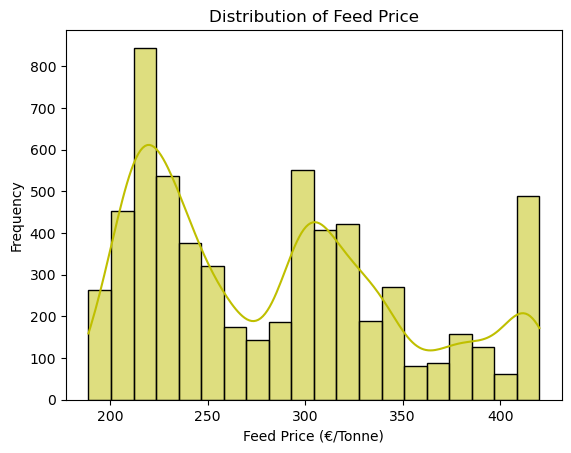

In [395]:
# Plot distribution of 'Price (€/Tonne)' to check for any change to distribution after imputation of missing values
sns.histplot(data = df, x = 'Feed Price (€/Tonne)', bins = 20, kde = True, color = 'y')
plt.title('Distribution of Feed Price')
plt.xlabel('Feed Price (€/Tonne)')
plt.ylabel('Frequency');

# Save the image else where to be used in report
plt.savefig('./Images/1_before_imputation_histogram.svg')

In [374]:
# Forward fill the missing values in the "Price (€/Tonne)" column
df["Feed Price (€/Tonne)"].bfill(inplace=True)

# Check result
print(df)

     Reference period Member State  Feed Price (€/Tonne)      Category  \
0          2022-12-12      Ireland                298.00  Young cattle   
1          2022-12-12      Ireland                298.00  Young cattle   
2          2022-12-12      Ireland                298.00  Young cattle   
3          2022-12-12      Ireland                298.00  Young cattle   
4          2022-12-12      Ireland                298.00  Young cattle   
...               ...          ...                   ...           ...   
6145       2021-01-18       France                216.08         Bulls   
6146       2021-01-11      Ireland                197.00         Bulls   
6147       2021-01-11       France                204.08         Bulls   
6148       2021-01-04      Ireland                196.00         Bulls   
6149       2021-01-04       France                   NaN         Bulls   

      Cattle Price  
0           406.10  
1           416.31  
2           491.00  
3           497.31  
4     

In [375]:
# Count the number of null values in each column
df.isnull().sum()

Reference period        0
Member State            0
Feed Price (€/Tonne)    1
Category                0
Cattle Price            0
dtype: int64

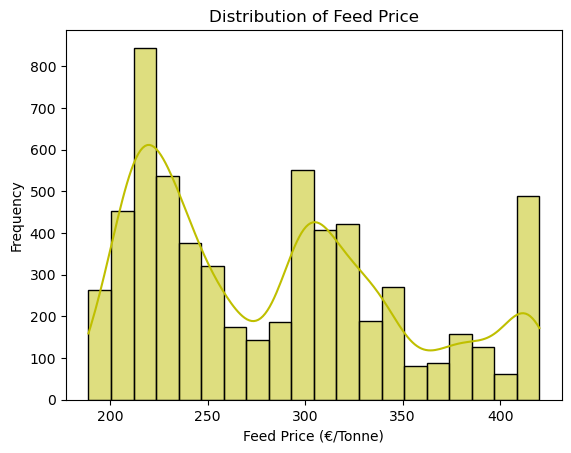

In [396]:
# Plot distribution of 'Price (€/Tonne)' to check for any change to distribution after imputation of missing values
sns.histplot(data = df, x = 'Feed Price (€/Tonne)', bins = 20, kde = True, color = 'y')
plt.title('Distribution of Feed Price')
plt.xlabel('Feed Price (€/Tonne)')
plt.ylabel('Frequency');

# Save the image else where to be used in report
plt.savefig('./Images/2_after_imputation_histogram.svg')

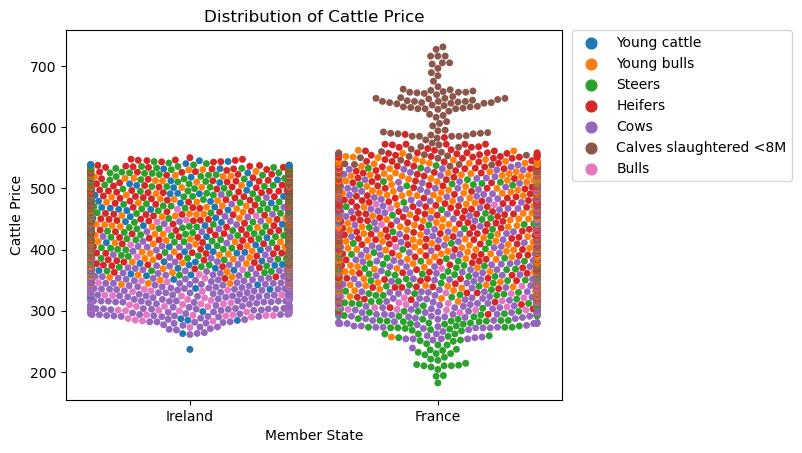

In [377]:
# Violin plot of price distribution of cattle by country
plt.title('Distribution of Cattle Price')
sns.swarmplot(data = df, x=df['Member State'], y=df['Cattle Price'], hue = 'Category')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

# Save the image else where to be used in report
plt.savefig('./Images/3_violin_plot.svg')

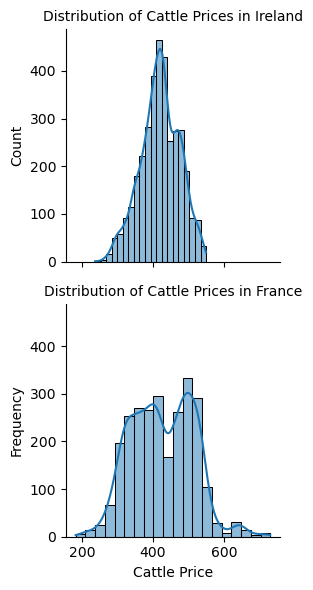

In [378]:
# Create a facet grid with the 'Country' column as the rows
g = sns.FacetGrid(df, row="Member State")

# Create a histogram plot on the grid with the 'Price' column as the x-axis
g.map(sns.histplot, "Cattle Price", bins=20, kde=True)

# Set the plot titles and labels
g.set_titles("Distribution of Cattle Prices in {row_name}")
plt.xlabel('Cattle Price')
plt.ylabel('Frequency');

# Save the image else where to be used in report
#plt.savefig('./Images/Img_1_BusDataframe_histogram.svg')

### Check to see if the data is linear before linear regression

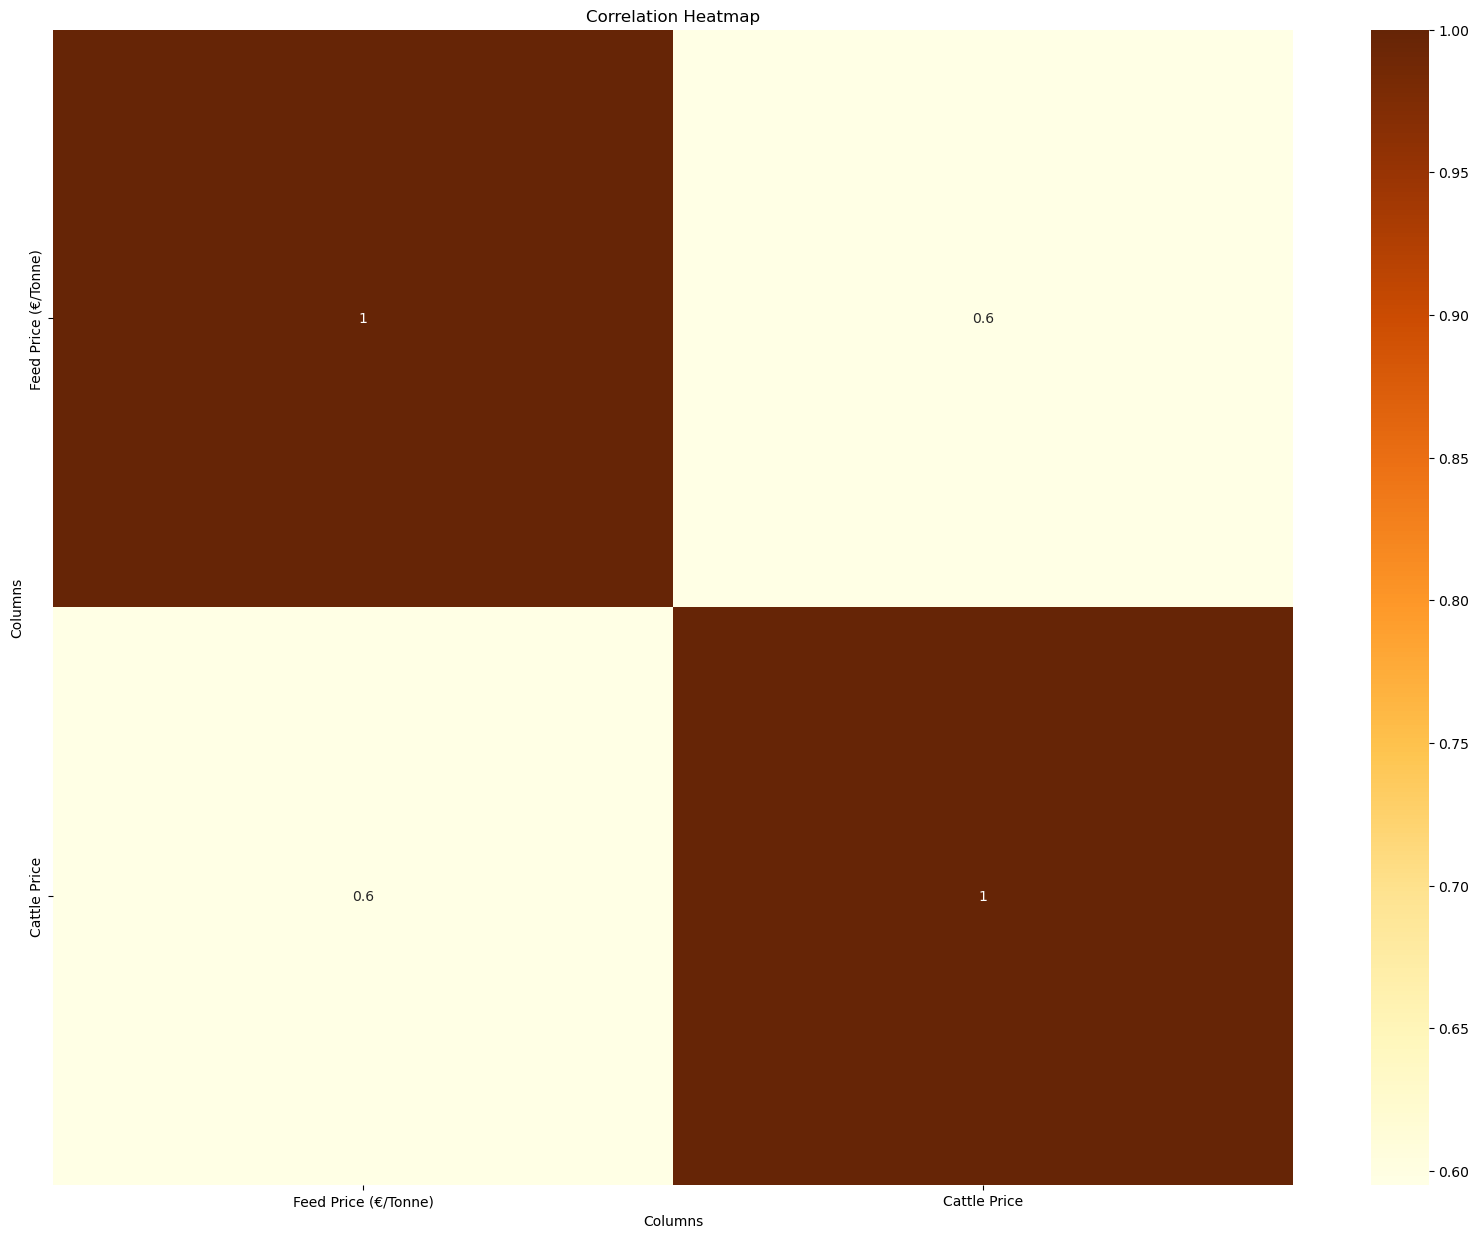

<Figure size 640x480 with 0 Axes>

In [398]:
# Compute the Pearson correlation between all pairs of columns
c_df = df.corr(method='pearson')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 15))

# Use the seaborn heatmap function to create a heatmap of the correlations
sns.heatmap(c_df, cmap='YlOrBr', annot=True)

# Set the plot title and labels
plt.title('Correlation Heatmap')
plt.xlabel('Columns')
plt.ylabel('Columns')

# Show the plot
plt.show()

# Save the image else where to be used in report
plt.savefig('./Images/4_pearson_corr_heatmap.svg')

The custom_barplot function is a custom function for visualizing the distribution of a column in a Pandas DataFrame. The function takes a DataFrame (df1) and a column name (col1) as input and creates a figure with four subplots: a histogram, a density plot, a Q-Q plot, and a box plot of the column.

The first two lines of the function check the size of the column and, if it has more than 5000 values, select a random sample of 5000 values from the column. This is done to avoid warnings about the size of the data being used with the Shapiro-Wilk test, which is unreliable with sample sizes larger than 5000, and for performance reasons.

The function then creates a figure and a 2x2 grid of subplots using plt.subplots. The histogram and density plot of the column are plotted using the plot method of the Pandas Series with the kind parameter set to 'hist' and 'kde', respectively. The Q-Q plot is created using the probplot function from the scipy.stats module. The box plot of the column is plotted using the plot method of the Pandas Series with the kind parameter set to 'box'.

Finally, the function calls the shapiro_test function to perform a Shapiro-Wilk test of normality on the column and returns the result as a tuple containing the status of the test (either 'Normal' or 'Not normal'), the color to use for the plot title, and the p-value of the test. The function then adds a plot title to the figure with the result of the normality test and the p-value.

There are a few ways you can improve the code:

Make the custom_barplot function more flexible by allowing it to accept multiple columns and countries, and to customize the title and labels of the plots. This way, you can use the function to create plots for different combinations of columns and countries without having to modify the function itself.

Use more descriptive and meaningful variable names. This can make the code easier to understand and maintain.

Use the seaborn library to create the plots. This library provides a variety of high-level plotting functions that can make your plots more visually appealing and easier to create.

Consider using the pandas plot method to create the plots. This method provides a convenient way to create various types of plots using the DataFrame and Series objects.

Use the matplotlib subplots function to create the plots. This function allows you to specify the number of rows and columns of subplots, and returns a tuple of the Figure and Axes objects. This can be more convenient than creating the plots manually.

Use matplotlib tight_layout function to adjust the layout of the plots. This can help avoid overlapping plots and text, and make the plots more visually appealing.

Consider using the scipy anderson_ksamp function to test for normality instead of the shapiro function. The anderson_ksamp

In [ ]:
def shapiro_test(x, color='blue'):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val

In [464]:
#winner winner chicken dinner
def custom_density_plot(df, countries, y_col, main_title, xlabel, ylabel, density_plot_title, box_plot_title):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    colors = ['green', 'blue']
    for i, country in enumerate(countries):
        data = df[df['Member State'] == country][y_col]
        sns.kdeplot(data, color=colors[i], label=country, ax=ax[0])
    ax[0].set_title(density_plot_title)
    sns.boxplot(x='Member State', y=y_col, data=df, hue='Member State', palette=['green', 'blue'], ax=ax[1])
    ax[1].set_title(box_plot_title)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
    sm.qqplot(df[df['Member State'] == 'Ireland'][y_col], ax=ax[0], line='s', color='green')
    ax[0].set_title('Ireland')
    ax[0].set_xlabel('Theoretical Quantiles')
    ax[0].set_ylabel('Sample Quantiles')
    sm.qqplot(df[df['Member State'] == 'France'][y_col], ax=ax[1], line='s', color='blue')
    ax[1].set_title('France')
    ax[1].set_xlabel('Theoretical Quantiles')
    ax[1].set_ylabel('Sample Quantiles')
    
    fig.suptitle(main_title)

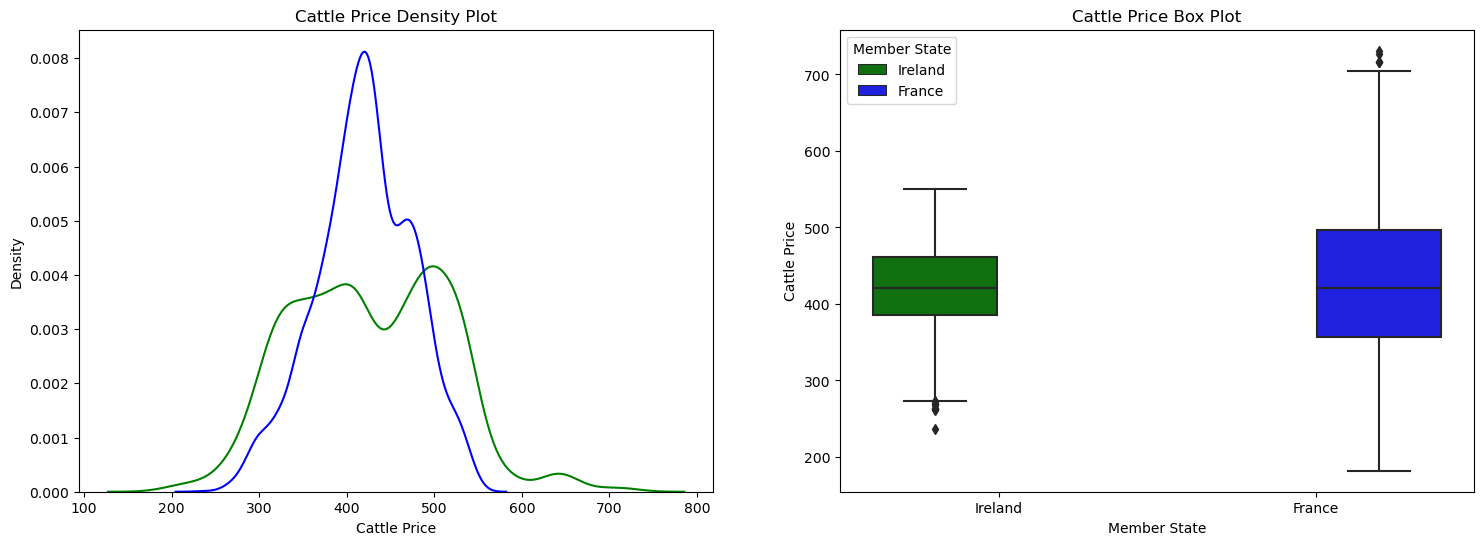

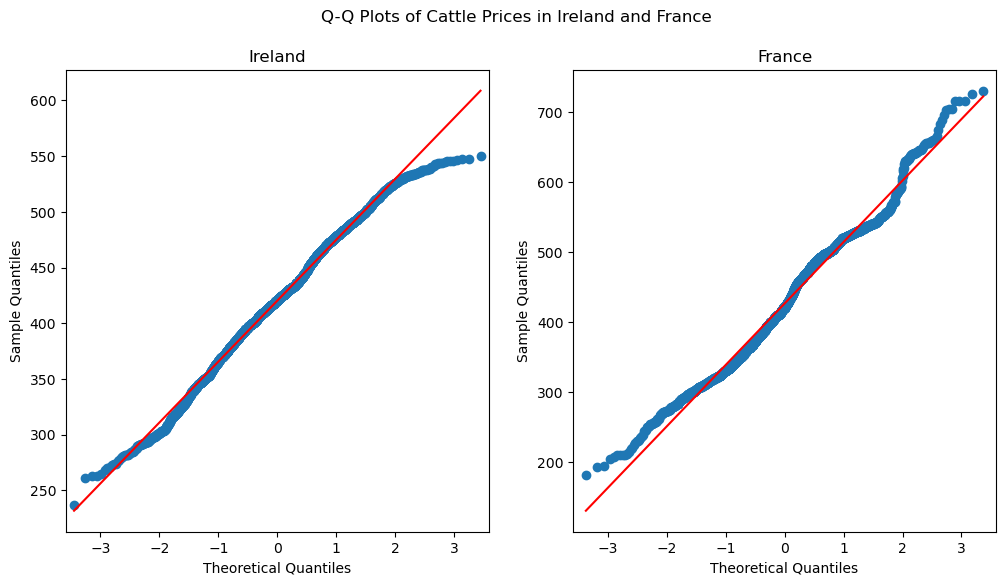

In [465]:
density_plot_title = 'Cattle Price Density Plot'
box_plot_title = 'Cattle Price Box Plot'
custom_density_plot(df, ['France', 'Ireland'], 
                    'Cattle Price', 
                    'Q-Q Plots of Cattle Prices in Ireland and France', 
                    'Country', 
                    'Cattle Price',
                    density_plot_title, 
                    box_plot_title)

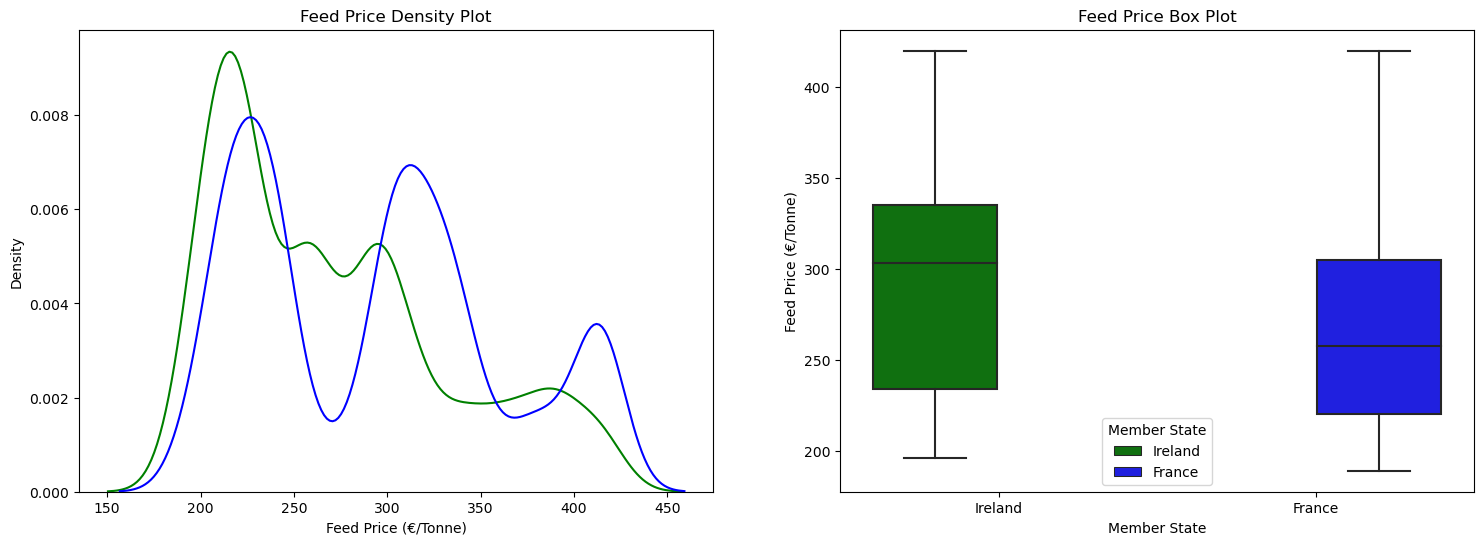

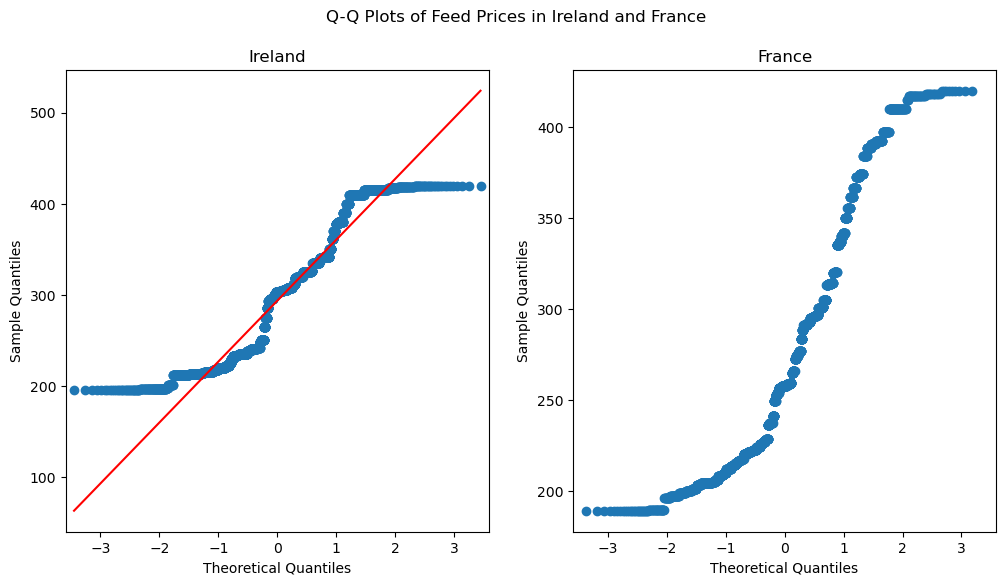

In [467]:
density_plot_title = 'Feed Price Density Plot'
box_plot_title = 'Feed Price Box Plot'
custom_density_plot(df, ['France', 'Ireland'], 
                    'Feed Price (€/Tonne)', 
                    'Q-Q Plots of Feed Prices in Ireland and France', 
                    'Country', 
                    'Feed Price',
                    density_plot_title, 
                    box_plot_title)

# Statistics

## Levene's test

To check if the variances of two samples are equal, you can use the Levene's test, which is a statistical test that compares the variances of two or more samples.

In [ ]:
#H0 = varience are equal
#H1 = variance are not equal

In [400]:
# Extract columns for t-test
ireland_beef = df[df['Member State'] == 'Ireland']['Cattle Price']
france_beef = df[df['Member State'] == 'France']['Cattle Price']

# Perform Levene's test
statistic, p_value = stats.levene(ireland_beef, france_beef)

print("statistic: ", statistic)
print("p-value: ", p_value)

statistic:  845.756379549518
p-value:  2.4750342451812578e-174


If the p-value is less than the predetermined threshold, 0.05, you can conclude that the variances of the two samples are not equal. In that case, you may need to use a different statistical test that does not assume equal variances, such as the Welch's t-test or the Brown-Forsythe test. However our p-value is 2.48 which is greater than 0.05. Therefore, it means that the observed results are not statistically significant and it is not possible to reject the null hypothesis. This does not necessarily mean that the null hypothesis is true, but rather that the observed data do not provide sufficient evidence to reject the null hypothesis.

*It's important to note that the Levene's test assumes that the data are normally distributed. If this assumption is not met, you may need to use a different test to compare the variances of the two samples.*

## T-test

In [ ]:
#H0 = means are equal
#H1 = means are not equal

In [401]:
# Perform t-test
t_statistic, p_value = stats.ttest_ind(ireland_beef, france_beef)

print("t-statistic: ", t_statistic)
print("p-value: ", p_value)

t-statistic:  -3.627042030759686
p-value:  0.0002890099620151181


## Non Parametric Test - Mann-Whitney U Test

#### H0 = no difference between the samples
#### H1 = there is a difference between the samples

In [404]:
statistic, p_value = mannwhitneyu(ireland_beef, france_beef)

print("U-statistic: ", statistic)
print("p-value: ", p_value)

U-statistic:  4453211.0
p-value:  0.008691585786716558


The U-statistic is a measure of the difference between the two samples, and the p-value is used to determine the statistical significance of the difference. If the p-value is less than 0.05, it can be concluded that there is a significant difference between the two samples.

The U-statistic is a measure of the difference between two samples in a Mann-Whitney U test. It is calculated as the sum of the ranks of the sample with the smaller size in the combined sample.

In the Mann-Whitney U test, the null hypothesis is that there is no difference between the two samples. The alternative hypothesis is that there is a difference between the samples. The U-statistic is used to determine the statistical significance of the difference between the samples.

If the U-statistic is small, it suggests that there is a significant difference between the samples. This is because a small U-statistic indicates that the ranks of the smaller sample are concentrated at the extremes of the combined sample, which suggests that the distributions of the two samples are different. On the other hand, if the U-statistic is large, it suggests that there is not a significant difference between the samples.

The U-statistic can be used in conjunction with the p-value to make a decision about the null hypothesis. If the p-value is less than 0.05, it can be concluded that there is a significant difference between the samples, and the null hypothesis can be rejected.

## Non Parametric Test - Wilcoxon Signed-rank test

not going to work because the samples are independent of each other

In [ ]:
# from scipy.stats import wilcoxon

# statistic, p_value = wilcoxon(ireland_beef, france_beef)

# print("Wilcoxon statistic: ", statistic)
# print("p-value: ", p_value)

The Wilcoxon statistic is a measure of the difference between the two samples, and the p-value is used to determine the statistical significance of the difference. If the p-value is less than 0.05, it can be concluded that there is a significant difference between the two samples.

It's important to note that the Wilcoxon signed-rank test is used when the samples are related, meaning that the observations in one sample are paired with observations in the other sample. This test is not appropriate for independent samples.

## Non Parametric Test - Chi-Square Test

The hypothesis test for a chi-square test is used to determine if there is a significant association between two categorical variables. The null hypothesis is that there is no association between the two variables, and the alternative hypothesis is that there is an association between the variables.

To perform the test, a contingency table is created to summarize the counts of each combination of the two variables. The chi-square test is then applied to the contingency table to determine the statistical significance of the association between the variables.

If the p-value obtained from the chi-square test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant association between the two variables, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant association between the variables, and the null hypothesis is accepted.

It's important to note that the chi-square test is used to determine if there is a significant association between two categorical variables. It is not appropriate for continuous or ordinal variables.

In [405]:
# Create contingency table
table = pd.crosstab(df['Feed Price (€/Tonne)'], df['Cattle Price'])

statistic, p_value, degrees_of_freedom, expected = chi2_contingency(table)

print("Chi-square statistic: ", statistic)
print("p-value: ", p_value)
print("degrees of freedom: ", degrees_of_freedom)
print("expected frequencies: ", expected)

Chi-square statistic:  339767.0028553361
p-value:  1.0
degrees of freedom:  453822
expected frequencies:  [[0.00439096 0.00439096 0.00439096 ... 0.01317287 0.00439096 0.00439096]
 [0.00439096 0.00439096 0.00439096 ... 0.01317287 0.00439096 0.00439096]
 [0.00796878 0.00796878 0.00796878 ... 0.02390633 0.00796878 0.00796878]
 ...
 [0.00975768 0.00975768 0.00975768 ... 0.02927305 0.00975768 0.00975768]
 [0.00780615 0.00780615 0.00780615 ... 0.02341844 0.00780615 0.00780615]
 [0.00715564 0.00715564 0.00715564 ... 0.02146691 0.00715564 0.00715564]]


The chi-square statistic is a measure of the difference between the observed and expected frequencies in the contingency table. It is calculated as the sum of the squared differences between the observed and expected frequencies, divided by the expected frequencies. The larger the chi-square statistic, the stronger the evidence against the null hypothesis (i.e., the more evidence there is for a significant association between the variables).

The p-value is used to determine the statistical significance of the association between the variables. It is the probability of obtaining a chi-square statistic as large as or larger than the observed value, given that the null hypothesis is true. If the p-value is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant association between the two variables, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant association between the variables, and the null hypothesis is accepted.

The degrees of freedom for a chi-square test are equal to the number of rows in the contingency table minus 1 multiplied by the number of columns in the table minus 1. The degrees of freedom are used to determine the critical value of the chi-square statistic, which is used to determine the p-value.

The expected frequencies are the frequencies that would be expected in each cell of the contingency table if the null hypothesis were true. They are calculated by taking the product of the row and column totals and dividing by the sample size. The expected frequencies are used to calculate the chi-square statistic and determine the statistical significance of the association between the variables.

## Fisher's Extract Test

The hypothesis test for a Fisher's exact test is used to determine if there is a significant association between two categorical variables. The null hypothesis is that there is no association between the two variables, and the alternative hypothesis is that there is an association between the variables.

To perform the test, a contingency table is created to summarize the counts of each combination of the two variables. The Fisher's exact test is then applied to the contingency table to determine the statistical significance of the association between the variables.

If the p-value obtained from the Fisher's exact test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant association between the two variables, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant association between the variables, and the null hypothesis is accepted.

It's important to note that the Fisher's exact test is used when the sample size is small or when the expected frequencies in the contingency table are small. It is not as powerful as the chi-square test for larger samples.

In [ ]:
# from scipy.stats import fisher_exact

# # Create contingency table
# table = pd.crosstab(df['Product'], df['Price'])

# odds_ratio, p_value = fisher_exact(table)

# print("Odds ratio: ", odds_ratio)
# print("p-value: ", p_value)

The sample size for a Fisher's exact test is considered small when the expected frequencies in the contingency table are less than 5. When the expected frequencies are less than 5, the chi-square test may not be reliable due to the underlying assumptions of the test. In such cases, the Fisher's exact test is a more appropriate alternative.

It's important to note that the Fisher's exact test is generally less powerful than the chi-square test, which means that it may be less able to detect significant differences between the observed and expected frequencies in the contingency table. As a result, it is generally recommended to use the chi-square test when the sample size is larger and the expected frequencies are greater than 5.

It's also worth noting that the sample size for a statistical test is not the only factor that should be considered when deciding which test to use. Other factors, such as the nature of the data and the research question being addressed, should also be taken into account.

## F-test

The hypothesis test for an F-test is used to determine if there is a significant difference between the means of two or more groups. The null hypothesis is that there is no difference between the means of the groups, and the alternative hypothesis is that there is a difference between the means of the groups.

To perform the test, the F-statistic is calculated as the ratio of the mean square between groups (MSB) to the mean square within groups (MSW). The p-value is then calculated using the F-distribution, which is the distribution of the F-statistic under the null hypothesis.

If the p-value obtained from the F-test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant difference between the means of the groups, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant difference between the means of the groups, and the null hypothesis is accepted.

It's important to note that the F-test is used to compare the means of two or more groups. It is not appropriate for comparing the means of two pairs of samples. To compare the means of two pairs of samples, you can use a t-test or a paired t-test.

In [406]:
# Perform F-test
statistic, p_value = f_oneway(ireland_beef, france_beef)

print("F-statistic: ", statistic)
print("p-value: ", p_value)

F-statistic:  13.155433892897271
p-value:  0.0002890099620148141


The F-statistic is a measure of the ratio of the variance between the groups to the variance within the groups. It is calculated as the ratio of the mean square between groups (MSB) to the mean square within groups (MSW). The larger the F-statistic, the stronger the evidence against the null hypothesis (i.e., the more evidence there is for a significant difference between the means of the groups).

The p-value is used to determine the statistical significance of the difference between the means of the groups. It is the probability of obtaining an F-statistic as large as or larger than the observed value, given that the null hypothesis is true. If the p-value is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant difference between the means of the groups, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant difference between the means of the groups, and the null hypothesis is accepted.

## Anova

Assumptions
1. Independence
2. Normally disributed
3. Quality of Variance

#### H0 = means are equal
#### H1 = at least one is not equal

One-way ANOVA and two-way ANOVA are both statistical tests used to compare the means of groups. The main difference between the two tests is the number of independent variables being considered.

One-way ANOVA is used to compare the means of three or more groups, where there is only one independent variable. For example, if you want to compare the mean heights of three different species of plants, species would be the independent variable, and height would be the dependent variable. One-way ANOVA is used to determine if there is a significant difference in the mean heights of the plants due to the effect of the species.

Two-way ANOVA is used to compare the means of groups, where there are two independent variables. For example, if you want to compare the mean heights of plants grown in two different soil types and exposed to two different levels of sunlight, soil type and sunlight exposure would be the independent variables, and height would be the dependent variable. Two-way ANOVA is used to determine if there is a significant difference in the mean heights of the plants due to the combined effects of the soil type and sunlight exposure.

Both one-way ANOVA and two-way ANOVA involve testing the null hypothesis that there is no difference between the means of the groups. If the p-value obtained from the test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant difference between the means of the groups, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant difference between the means of the groups, and the null hypothesis is accepted.

In [ ]:
df

In [ ]:
# Drop the unit column
df = df.drop(columns=['Product', 'Week'])

In [ ]:
df

# Machine Learning

## Decision Tree

In [ ]:
df = pd.get_dummies(df, columns=['Member State', 'Category'])

In [ ]:
# Create the independent and dependent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Load the library 'sklearn.tree'
from sklearn.tree import DecisionTreeRegressor

# Create and initialize a DecisionTreeRegressor with a maximum depth of 5
regressor = DecisionTreeRegressor(max_depth=6, random_state=0)

# Define the hyperparameter space
param_grid = {'max_depth': range(1, 10)}

# Create a grid search object
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_:.2f}')

# Train the classifier on the entire dataset using the best parameters
regressor = DecisionTreeRegressor(**grid_search.best_params_)
regressor.fit(X, y)

# Calculate the predicted value by calling a method predict()
y_pred = regressor.predict(X_test)


In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

In [ ]:
# Set the size of the figure
plt.figure(figsize = (12, 8))

# Display the tree by calling a method plot_tree()
tree.plot_tree(regressor.fit(X_train, y_train),filled=True, rounded=True, precision=2) ;

In [ ]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

In [ ]:
print(f'R2 Score: {round(r2,4)}')
print(f'MAE Score: {round(mae,4)}')
print(f'MSE Score: {round(mse,4)}')
print(f'RMSE Score: {round(rmse,4)}')

## Random Forest

In [ ]:
# Create and initialise a RandomForestRegressor
rf_regressor = RandomForestRegressor(max_depth = 4, random_state = 0)

In [ ]:
param_grid = {'n_estimators': [5, 10, 20, 30], 
              'max_depth' : [17, 18, 19, 20, 21, 22, 23]}

In [ ]:
cv_rfc = GridSearchCV(estimator=regressor, param_grid=param_grid,return_train_score=True, scoring='r2', cv= 10)
cv_rfc.fit(X_train, y_train)

In [ ]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

In [ ]:
# Create and initialise a RandomForestRegressor
regressor = RandomForestRegressor( n_estimators = 10, max_depth = 20, random_state = 0, n_jobs = -1)

# Train the classifier by calling a method 'fit()'
regressor.fit(X_train, y_train)

In [ ]:
# Calculate the predicted vlaue by calling a method predict()
y_pred = regressor.predict(X_test)

In [ ]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

In [ ]:
metrics.r2_score(y_test, y_pred)

In [ ]:
print(f'R2 Score: {r2}')
print(f'MAE Score: {mae}')
print(f'MSE Score: {mse}')
print(f'RMSE Score: {rmse}')